In [35]:
import pandas as pd
import numpy as np

In [36]:
df = pd.read_csv('datanew2.csv')

In [37]:
df['late'] = df['days_for_shipping_(real)'] > df['days_for_shipment_(scheduled)']

In [38]:
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, roc_auc_score


# Define features and target variable
features = ['type', 'days_for_shipment_(scheduled)', 'shipping_mode', 
            'order_region', 'order_status', 'benefit_per_order', 
            'sales_per_customer', 'customer_city', 'customer_state', 
            'category_name', 'product_price', 'latitude', 'longitude']
target = 'late'

X = df[features]
y = df[target]

# Preprocess the data
categorical_features = ['type', 'shipping_mode', 'order_region', 'order_status', 
                        'customer_city', 'customer_state', 'category_name']
numerical_features = ['days_for_shipment_(scheduled)', 'benefit_per_order', 
                      'sales_per_customer', 'product_price', 'latitude', 'longitude']

# One-hot encode categorical variables and scale numerical variables
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)
X_processed = preprocessor.fit_transform(X)

# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Train Random Forest Classifier
model = RandomForestClassifier(random_state=42)
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)
y_pred_proba = model.predict_proba(X_test)[:, 1]

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Classification Report:
               precision    recall  f1-score   support

       False       0.72      0.81      0.76      5345
        True       0.84      0.76      0.80      7101

    accuracy                           0.78     12446
   macro avg       0.78      0.79      0.78     12446
weighted avg       0.79      0.78      0.78     12446

ROC AUC Score: 0.8673391631555866


In [39]:
importances = model.feature_importances_
feature_names = preprocessor.get_feature_names_out()
feature_importances = pd.DataFrame({'Feature': feature_names, 'Importance': importances})
print(feature_importances.sort_values(by='Importance', ascending=False))

                                Feature    Importance
656                       num__latitude  1.083814e-01
652  num__days_for_shipment_(scheduled)  1.014034e-01
653              num__benefit_per_order  9.753897e-02
657                      num__longitude  9.609239e-02
654             num__sales_per_customer  9.482630e-02
..                                  ...           ...
419            cat__customer_city_Ponce  1.891355e-05
296          cat__customer_city_Lombard  1.764236e-05
273        cat__customer_city_La Puente  1.586644e-05
36          cat__customer_city_Asheboro  1.253646e-05
190         cat__customer_city_Freehold  2.179212e-07

[658 rows x 2 columns]


In [40]:
threshold = 0.6
y_pred_custom = (y_pred_proba >= threshold).astype(int)
print("Adjusted Classification Report:\n", classification_report(y_test, y_pred_custom))

Adjusted Classification Report:
               precision    recall  f1-score   support

       False       0.67      0.90      0.77      5345
        True       0.90      0.67      0.77      7101

    accuracy                           0.77     12446
   macro avg       0.78      0.78      0.77     12446
weighted avg       0.80      0.77      0.77     12446



In [41]:
print(df['late'].dtype)
import scipy.stats as stats

# Select only the factor variables (categorical variables)
factor_vars = df.select_dtypes(include=['object', 'bool']).columns

# List to store significant variables
significant_vars = []

# Run chi-square test for each factor variable in relation to 'late'
for var in factor_vars:
    contingency_table = pd.crosstab(df[var], df['late'])
    chi2, p, dof, expected = stats.chi2_contingency(contingency_table)
    print(f"Chi-square test for {var}:")
    print(f"Chi2: {chi2}, p-value: {p}\n")
    if p < 0.05:
        significant_vars.append(var)

print("Significant variables with p-value < 0.05:")
print(significant_vars)

bool


Chi-square test for type:
Chi2: 9.143967864174677, p-value: 0.027436746912424887

Chi-square test for late:
Chi2: 62224.91303289871, p-value: 0.0

Chi-square test for delivery_status:
Chi2: 59425.842580935525, p-value: 0.0

Chi-square test for category_name:
Chi2: 28.996004932055737, p-value: 0.5178065835735203

Chi-square test for customer_city:
Chi2: 1780.9612094094016, p-value: 7.106886615747253e-127

Chi-square test for customer_country:
Chi2: 0.6070032780043393, p-value: 0.4359183651459547

Chi-square test for customer_email:
Chi2: 0.0, p-value: 1.0

Chi-square test for customer_fname:
Chi2: 662.6284220672023, p-value: 3.439747035448566e-51

Chi-square test for customer_lname:
Chi2: 3813.7788424992495, p-value: 0.0

Chi-square test for customer_password:
Chi2: 0.0, p-value: 1.0

Chi-square test for customer_segment:
Chi2: 2.6085668206764163, p-value: 0.27136692412105806

Chi-square test for customer_state:
Chi2: 85.45942556655939, p-value: 0.00012487483389287548

Chi-square test f

In [42]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import log_loss

# Define features and target
features = ['type', 'days_for_shipment_(scheduled)', 'shipping_mode', 
            'order_region', 'order_status', 'benefit_per_order', 
            'sales_per_customer', 'category_name', 'product_price', 'latitude', 'longitude']
target = 'late'

X = df[features]
y = df[target]

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess the data
categorical_features = ['type', 'shipping_mode', 'order_region', 'order_status', 'category_name']
numerical_features = ['days_for_shipment_(scheduled)', 'benefit_per_order', 'sales_per_customer', 'product_price', 'latitude', 'longitude']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Create a pipeline for logistic regression
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced'))  # Add class weights if needed
])

# Train the logistic regression model
logistic_pipeline.fit(X_train, y_train)

# Make predictions
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]  # Probabilities for the positive class
y_pred = (y_pred_proba >= 0.5).astype(int)  # Use a default threshold of 0.5

# Evaluate the model
print("Classification Report:\n", classification_report(y_test, y_pred))
print("ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))
print("Log-Loss:", log_loss(y_test, y_pred_proba))

# Adjust the threshold for predictions (optional)
threshold = 0.6  # Example: Use 0.6 to minimize false negatives
y_pred_custom = (y_pred_proba >= threshold).astype(int)

print("\nAdjusted Classification Report (Threshold = 0.6):\n", classification_report(y_test, y_pred_custom))

Classification Report:
               precision    recall  f1-score   support

       False       0.60      0.91      0.72      5345
        True       0.88      0.54      0.67      7101

    accuracy                           0.70     12446
   macro avg       0.74      0.72      0.69     12446
weighted avg       0.76      0.70      0.69     12446

ROC AUC Score: 0.7452371363919414
Log-Loss: 0.5462908010671877

Adjusted Classification Report (Threshold = 0.6):
               precision    recall  f1-score   support

       False       0.60      0.91      0.72      5345
        True       0.88      0.54      0.67      7101

    accuracy                           0.70     12446
   macro avg       0.74      0.72      0.69     12446
weighted avg       0.76      0.70      0.69     12446



In [43]:
# Feature Engineering
# 1. Interaction terms: Create interactions between important features
df['shipment_efficiency'] = df['days_for_shipment_(scheduled)'] / (df['benefit_per_order'] + 1)
df['price_per_customer'] = df['product_price'] / (df['sales_per_customer'] + 1)

# 2. Extract categorical feature information (if applicable)
df['is_high_value_order'] = (df['benefit_per_order'] > 50).astype(int)

# 3. Encoding date features (e.g., shipping or order date)
df['order_weekday'] = pd.to_datetime(df['order_date_(dateorders)']).dt.weekday
df['is_weekend'] = df['order_weekday'].isin([5, 6]).astype(int)

In [44]:
# Correlation matrix
corr_matrix = df.select_dtypes(include=[np.number]).corr()

# Select features with high correlation (absolute correlation > 0.8)
high_corr_features = [column for column in corr_matrix.columns if any(abs(corr_matrix[column]) > 0.8)]
print("Highly correlated features to review for removal:", high_corr_features)

Highly correlated features to review for removal: ['days_for_shipping_(real)', 'days_for_shipment_(scheduled)', 'late?', 'benefit_per_order', 'sales_per_customer', 'late_delivery_risk', 'category_id', 'customer_id', 'customer_zipcode', 'department_id', 'latitude', 'longitude', 'order_customer_id', 'order_id', 'order_item_cardprod_id', 'order_item_discount', 'order_item_discount_rate', 'order_item_id', 'order_item_product_price', 'order_item_profit_ratio', 'order_item_quantity', 'sales', 'order_item_total', 'order_profit_per_order', 'product_card_id', 'product_category_id', 'product_price', 'shipment_efficiency', 'price_per_customer', 'is_high_value_order', 'order_weekday', 'is_weekend']


In [45]:
# Drop redundant or highly correlated features
features_to_drop = [
    'days_for_shipping_(real)', 'latitude', 'longitude', 'order_id', 
    'order_customer_id', 'customer_id', 'customer_zipcode', 
    'department_id', 'order_item_cardprod_id', 'order_item_discount',
    'order_item_discount_rate', 'order_item_id', 'order_item_product_price', 
    'order_item_profit_ratio', 'sales', 'order_item_total', 'order_profit_per_order', 
    'product_card_id', 'product_category_id', 'benefit_per_order', 
    'product_price', 'sales_per_customer'
]
df = df.drop(columns=features_to_drop)

print("Remaining Features:", df.columns)

Remaining Features: Index(['type', 'days_for_shipment_(scheduled)', 'late?', 'late',
       'delivery_status', 'late_delivery_risk', 'category_id', 'category_name',
       'customer_city', 'customer_country', 'customer_email', 'customer_fname',
       'customer_lname', 'customer_password', 'customer_segment',
       'customer_state', 'customer_street', 'department_name', 'market',
       'order_city', 'order_country', 'order_date_(dateorders)',
       'order_item_quantity', 'order_region', 'order_state', 'order_status',
       'order_zipcode', 'product_image', 'product_name',
       'shipping_date_(dateorders)', 'shipping_mode', 'shipment_efficiency',
       'price_per_customer', 'is_high_value_order', 'order_weekday',
       'is_weekend'],
      dtype='object')


In [46]:
# Define updated features
features = [
    'type', 'shipping_mode', 'order_region', 'order_status', 
    'shipment_efficiency', 'price_per_customer', 'is_high_value_order', 
    'order_weekday', 'is_weekend'
]

X = df[features]
y = df[target]

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Preprocess categorical and numerical features
categorical_features = ['type', 'shipping_mode', 'order_region', 'order_status']
numerical_features = ['shipment_efficiency', 'price_per_customer', 'is_high_value_order', 'order_weekday', 'is_weekend']

preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('num', StandardScaler(), numerical_features)
    ]
)

# Train logistic regression with the simplified dataset
logistic_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced'))
])

logistic_pipeline.fit(X_train, y_train)

# Evaluate the model
y_pred_proba = logistic_pipeline.predict_proba(X_test)[:, 1]
y_pred = (y_pred_proba >= 0.5).astype(int)

print("Simplified Model - Classification Report:\n", classification_report(y_test, y_pred))
print("Simplified Model - ROC AUC Score:", roc_auc_score(y_test, y_pred_proba))

Simplified Model - Classification Report:
               precision    recall  f1-score   support

       False       0.60      0.91      0.72      5345
        True       0.88      0.54      0.67      7101

    accuracy                           0.70     12446
   macro avg       0.74      0.72      0.69     12446
weighted avg       0.76      0.70      0.69     12446

Simplified Model - ROC AUC Score: 0.7471800635729113


In [47]:
# Adjust threshold to minimize false negatives (e.g., improve recall for late deliveries)
threshold = 0.4  # Adjust this value as needed
y_pred_custom = (y_pred_proba >= threshold).astype(int)

print("Adjusted Classification Report (Threshold = 0.4):\n", classification_report(y_test, y_pred_custom))

Adjusted Classification Report (Threshold = 0.4):
               precision    recall  f1-score   support

       False       0.61      0.85      0.71      5345
        True       0.84      0.58      0.69      7101

    accuracy                           0.70     12446
   macro avg       0.72      0.72      0.70     12446
weighted avg       0.74      0.70      0.70     12446



In [48]:
# Test different thresholds
thresholds = [0.3, 0.35, 0.4, 0.45, 0.5]
for threshold in thresholds:
    y_pred_custom = (y_pred_proba >= threshold).astype(int)
    print(f"Threshold: {threshold}")
    print(classification_report(y_test, y_pred_custom))

Threshold: 0.3
              precision    recall  f1-score   support

       False       0.68      0.02      0.04      5345
        True       0.57      0.99      0.73      7101

    accuracy                           0.57     12446
   macro avg       0.63      0.51      0.38     12446
weighted avg       0.62      0.57      0.43     12446

Threshold: 0.35
              precision    recall  f1-score   support

       False       0.61      0.70      0.65      5345
        True       0.75      0.66      0.70      7101

    accuracy                           0.68     12446
   macro avg       0.68      0.68      0.68     12446
weighted avg       0.69      0.68      0.68     12446

Threshold: 0.4
              precision    recall  f1-score   support

       False       0.61      0.85      0.71      5345
        True       0.84      0.58      0.69      7101

    accuracy                           0.70     12446
   macro avg       0.72      0.72      0.70     12446
weighted avg       0.74     

1.	Threshold: 0.3
- Recall (True): 99% - Very high recall for predicting late deliveries (True class), meaning almost all late deliveries are captured.
- Precision (True): 57% - Precision drops significantly, meaning many false positives (on-time predicted as late).
- Accuracy: 57% - Overall accuracy suffers due to a high number of false positives.
2.	Threshold: 0.35
- Recall (True): 66% - Recall improves compared to the default threshold but drops from 99% at 0.3.
- Precision (True): 75% - Better balance between precision and recall.
- Accuracy: 68% - Higher than threshold 0.3 but still slightly lower than 0.4.
3.	Threshold: 0.4
- Recall (True): 58% - Captures fewer late deliveries compared to lower thresholds but has fewer false positives.
- Precision (True): 84% - Highest precision among the thresholds, with better identification of true late deliveries.
- Accuracy: 70% - Best overall accuracy.

Recommendation
1.	If Recall is a Priority (e.g., minimizing missed late deliveries):
Use Threshold 0.35:
It balances recall (66%) and precision (75%) well.
Accuracy (68%) is acceptable.
2.	If Precision and Accuracy are More Important:
Use Threshold 0.4:
Best overall accuracy (70%).
High precision (84%) ensures that predicted late deliveries are mostly correct.

In [49]:
# Logistic regression coefficients for feature importance
coefficients = logistic_pipeline.named_steps['classifier'].coef_[0]
cat_feature_names = logistic_pipeline.named_steps['preprocessor'].transformers_[0][1].get_feature_names_out()
num_feature_names = numerical_features
feature_names = np.concatenate([cat_feature_names, num_feature_names])
feature_importance = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

print(feature_importance.head(10))  # Top 10 important features

                         Feature  Coefficient  Abs_Coefficient
5   shipping_mode_Standard Class    -6.504608         6.504608
3         shipping_mode_Same Day    -6.142536         6.142536
4     shipping_mode_Second Class    -4.790528         4.790528
10           order_status_CLOSED     1.361631         1.361631
2                  type_TRANSFER     1.130960         1.130960
1                   type_PAYMENT     0.905492         0.905492
0                     type_DEBIT     0.889159         0.889159
15  order_status_PENDING_PAYMENT     0.509510         0.509510
12          order_status_ON_HOLD     0.454345         0.454345
11         order_status_COMPLETE     0.434814         0.434814


In [50]:
for region in df['order_region'].unique():
    subset = X_test[df['order_region'] == region]
    subset_y = y_test[df['order_region'] == region]
    subset_pred = logistic_pipeline.predict(subset)
    print(f"Performance for Region {region}:")
    print(classification_report(subset_y, subset_pred))

Performance for Region West of USA :
              precision    recall  f1-score   support

       False       0.62      0.92      0.74       690
        True       0.90      0.56      0.69       881

    accuracy                           0.72      1571
   macro avg       0.76      0.74      0.71      1571
weighted avg       0.78      0.72      0.71      1571

Performance for Region Central America:
              precision    recall  f1-score   support

       False       0.60      0.91      0.72      2444
        True       0.89      0.55      0.68      3260

    accuracy                           0.70      5704
   macro avg       0.75      0.73      0.70      5704
weighted avg       0.77      0.70      0.70      5704

Performance for Region South America:
              precision    recall  f1-score   support

       False       0.57      0.89      0.69      1262
        True       0.87      0.52      0.65      1772

    accuracy                           0.67      3034
   macro avg 

/tmp/ipykernel_98722/3721552809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = X_test[df['order_region'] == region]
/tmp/ipykernel_98722/3721552809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = X_test[df['order_region'] == region]
/tmp/ipykernel_98722/3721552809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = X_test[df['order_region'] == region]
/tmp/ipykernel_98722/3721552809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = X_test[df['order_region'] == region]
/tmp/ipykernel_98722/3721552809.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  subset = X_test[df['order_region'] == region]


In [51]:
from sklearn.model_selection import cross_val_score

scores = cross_val_score(logistic_pipeline, X, y, cv=5, scoring='roc_auc')
print("Cross-validated ROC AUC scores:", scores)
print("Average ROC AUC:", scores.mean())

Cross-validated ROC AUC scores: [0.7410699  0.76897883 0.72572491 0.73664196 0.73002175]
Average ROC AUC: 0.7404874680836957


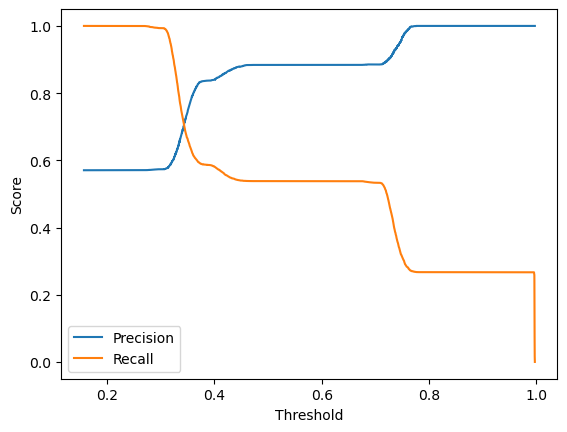

In [52]:
from sklearn.metrics import precision_recall_curve, roc_curve
import matplotlib.pyplot as plt

precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
plt.plot(thresholds, precision[:-1], label='Precision')
plt.plot(thresholds, recall[:-1], label='Recall')
plt.xlabel('Threshold')
plt.ylabel('Score')
plt.legend()
plt.show()

In [53]:
false_positives = X_test[(y_test == 0) & (y_pred == 1)]
false_negatives = X_test[(y_test == 1) & (y_pred == 0)]
print("False Positives Sample:")
print(false_positives.head())
print("False Negatives Sample:")
print(false_negatives.head())

False Positives Sample:
           type shipping_mode     order_region     order_status  \
41868  TRANSFER  Second Class  Central America          PENDING   
31108   PAYMENT  Second Class    South America  PENDING_PAYMENT   
14804   PAYMENT  Second Class    South America  PENDING_PAYMENT   
12668   PAYMENT  Second Class    South America  PENDING_PAYMENT   
54522  TRANSFER  Second Class    South America         CANCELED   

       shipment_efficiency  price_per_customer  is_high_value_order  \
41868            -0.025413            0.254453                    0   
31108             0.044944            0.285714                    0   
14804             0.066867            0.215994                    0   
12668            -0.025413            0.219300                    0   
54522             0.025733            0.380720                    1   

       order_weekday  is_weekend  
41868              3           0  
31108              0           0  
14804              5           1  
12668 

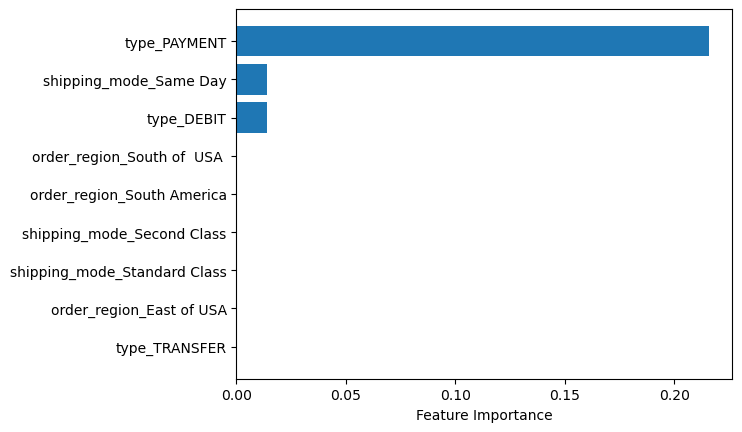

In [54]:
from sklearn.inspection import permutation_importance
import matplotlib.pyplot as plt

importance = permutation_importance(logistic_pipeline, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = importance.importances_mean.argsort()
plt.barh(range(len(sorted_idx)), importance.importances_mean[sorted_idx], align='center')
plt.yticks(range(len(sorted_idx)), [feature_names[i] for i in sorted_idx])
plt.xlabel("Feature Importance")
plt.show()

1.	Region-Specific Performance:
- The performance of the model varies across regions. For instance:
- West of USA shows a good balance between precision and recall for the “True” class.
- Central America has similar precision, but recall is slightly lower.
- South America’s recall is lower compared to others.
- This indicates the model’s predictive power is region-dependent.
2.	Cross-Validation Results:
- Cross-validation shows an average ROC AUC of ~0.74, which confirms the model has a moderate ability to distinguish between late and on-time deliveries across different splits of the data.
- This is consistent with the testing set’s ROC AUC, validating the model’s robustness.
3.	Feature Importance:
- Features like shipping_mode and order_status have significant influence on the predictions.
- shipping_mode_Standard Class and shipping_mode_Same Day have negative coefficients, meaning they reduce the likelihood of late delivery.
4.	Precision-Recall Tradeoff:
- By adjusting the threshold (e.g., 0.3, 0.35, 0.4), you can trade between precision and recall based on business needs.
- For example, a threshold of 0.4 improves recall for late deliveries, ensuring fewer false negatives.

In [55]:
region_specific_models = {}
for region in df['order_region'].unique():
    subset_X = X[df['order_region'] == region]
    subset_y = y[df['order_region'] == region]
    
    # Preprocess the subset data
    subset_X_processed = preprocessor.transform(subset_X)
    
    model = LogisticRegression(max_iter=500, class_weight='balanced')
    model.fit(subset_X_processed, subset_y)
    region_specific_models[region] = model

In [56]:
from sklearn.metrics import precision_recall_curve
optimal_threshold = None
max_f1 = 0
precision, recall, thresholds = precision_recall_curve(y_test, y_pred_proba)
for p, r, t in zip(precision, recall, thresholds):
    f1 = 2 * (p * r) / (p + r)
    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = t
print(f"Optimal Threshold: {optimal_threshold}, Max F1: {max_f1}")

Optimal Threshold: 0.30951810420777637, Max F1: 0.7277818106398424


In [57]:
# Define a new preprocessor for the simplified dataset
simplified_categorical_features = ['shipping_mode', 'type', 'order_status', 'order_region']
simplified_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), simplified_categorical_features)
    ]
)

In [58]:
# Align indices of features and labels
simplified_X = X.loc[y_train.index, simplified_categorical_features]
simplified_X_processed = simplified_preprocessor.fit_transform(simplified_X)

In [59]:
# Select the simplified features
simplified_features = ['shipping_mode', 'type', 'order_status', 'order_region']
simplified_X = X[simplified_features]

# Align indices of features and labels
simplified_X = X.loc[y_train.index, simplified_features]

# Transform the simplified dataset
simplified_X_processed = simplified_preprocessor.fit_transform(simplified_X)

# Train the logistic regression model
simplified_model = LogisticRegression(max_iter=500, class_weight='balanced')
simplified_model.fit(simplified_X_processed, y_train)

# Evaluate the simplified model
y_pred_simplified = simplified_model.predict(simplified_X_processed)
print("Simplified Model Performance:")
print(classification_report(y_train, y_pred_simplified))

Simplified Model Performance:
              precision    recall  f1-score   support

       False       0.59      0.90      0.71     21229
        True       0.88      0.53      0.66     28554

    accuracy                           0.69     49783
   macro avg       0.74      0.72      0.69     49783
weighted avg       0.76      0.69      0.69     49783



In [60]:
from sklearn.metrics import precision_recall_curve, roc_curve

# Calculate precision, recall, and thresholds
precision, recall, thresholds = precision_recall_curve(y_train, simplified_model.predict_proba(simplified_X_processed)[:, 1])

# Find the optimal threshold (maximizing F1-Score)
optimal_threshold = None
max_f1 = 0
for p, r, t in zip(precision, recall, thresholds):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = t

print(f"Optimal Threshold: {optimal_threshold}, Max F1: {max_f1}")

# Apply the optimal threshold
y_pred_optimized = (simplified_model.predict_proba(simplified_X_processed)[:, 1] >= optimal_threshold).astype(int)

# Evaluate with the optimal threshold
from sklearn.metrics import classification_report
print("Performance with Optimal Threshold:")
print(classification_report(y_train, y_pred_optimized))

Optimal Threshold: 0.2703325777511358, Max F1: 0.7293429089886778
Performance with Optimal Threshold:
              precision    recall  f1-score   support

       False       0.80      0.00      0.01     21229
        True       0.57      1.00      0.73     28554

    accuracy                           0.57     49783
   macro avg       0.68      0.50      0.37     49783
weighted avg       0.67      0.57      0.42     49783



In [82]:
# Ensure 'order_region' is included in the features
if 'order_region' not in simplified_features:
    simplified_features.append('order_region')

# Select the simplified features
simplified_X = X[simplified_features]

# Ensure indices of X and y are aligned
simplified_X = simplified_X.loc[y_train.index]

# Evaluate the model for each region
for region in simplified_X['order_region'].unique():
    # Subset the data for the region
    region_X = simplified_X[simplified_X['order_region'] == region]
    region_y = y_train.loc[region_X.index]  # Align y labels with the subset X indices
    
    # Transform the subset data
    region_X_processed = simplified_preprocessor.transform(region_X)
    
    # Predict using the simplified model
    region_y_pred = simplified_model.predict(region_X_processed)
    
    # Print performance metrics for the region
    print(f"Performance for Region {region}:")
    print(classification_report(region_y, region_y_pred))
    
    # Save the performance metrics for each region as a DataFrame
    performance_metrics = []

    for region in simplified_X['order_region'].unique():
        # Subset the data for the region
        region_X = simplified_X[simplified_X['order_region'] == region]
        region_y = y_train.loc[region_X.index]  # Align y labels with the subset X indices
        
        # Transform the subset data
        region_X_processed = simplified_preprocessor.transform(region_X)
        
        # Predict using the simplified model
        region_y_pred = simplified_model.predict(region_X_processed)
        
        # Calculate performance metrics
        report = classification_report(region_y, region_y_pred, output_dict=True)
        performance_metrics.append({
            'Region': region,
            'Precision_True': report['True']['precision'],
            'Recall_True': report['True']['recall'],
            'F1-Score_True': report['True']['f1-score'],
            'Precision_False': report['False']['precision'],
            'Recall_False': report['False']['recall'],
            'F1-Score_False': report['False']['f1-score']
        })

    # Convert the list of dictionaries to a DataFrame
    performance_metrics_df = pd.DataFrame(performance_metrics)
    print(performance_metrics_df)

Performance for Region West of USA :
              precision    recall  f1-score   support

       False       0.60      0.91      0.72      2779
        True       0.88      0.54      0.67      3643

    accuracy                           0.70      6422
   macro avg       0.74      0.72      0.70      6422
weighted avg       0.76      0.70      0.69      6422

            Region  Precision_True  Recall_True  F1-Score_True  \
0     West of USA         0.882221     0.540763       0.670524   
1  Central America        0.877387     0.531549       0.662023   
2   South of  USA         0.900350     0.544974       0.678972   
3      East of USA        0.887687     0.525145       0.659900   
4    South America        0.883664     0.532468       0.664518   

   Precision_False  Recall_False  F1-Score_False  
0         0.600621      0.905362        0.722158  
1         0.589190      0.900445        0.712300  
2         0.586936      0.914671        0.715038  
3         0.573851      0.905872   

In [62]:
# Train a baseline model (e.g., Decision Tree Classifier)
from sklearn.tree import DecisionTreeClassifier

baseline_model = DecisionTreeClassifier(max_depth=5, random_state=42, class_weight='balanced')
baseline_model.fit(simplified_X_processed, y_train)

# Evaluate the baseline model
baseline_y_pred = baseline_model.predict(simplified_X_processed)
print("Baseline Model Performance:")
print(classification_report(y_train, baseline_y_pred))

Baseline Model Performance:
              precision    recall  f1-score   support

       False       0.59      0.90      0.71     21229
        True       0.88      0.54      0.67     28554

    accuracy                           0.69     49783
   macro avg       0.74      0.72      0.69     49783
weighted avg       0.76      0.69      0.69     49783



In [63]:
# Retrieve feature names from the preprocessor
from sklearn.compose import ColumnTransformer

# Ensure you get the names of the one-hot encoded columns
encoded_feature_names = simplified_preprocessor.named_transformers_['cat'].get_feature_names_out(simplified_categorical_features)

# Combine all feature names (only categorical here as no numerical in simplified features)
final_feature_names = encoded_feature_names

# Retrieve coefficients from the logistic regression model
coefficients = simplified_model.coef_[0]

# Create a DataFrame for feature importance
feature_importance = pd.DataFrame({
    'Feature': final_feature_names,
    'Coefficient': coefficients
})

# Calculate absolute coefficients for ranking
feature_importance['Abs_Coefficient'] = feature_importance['Coefficient'].abs()

# Sort by absolute coefficient values
feature_importance = feature_importance.sort_values(by='Abs_Coefficient', ascending=False)

# Display the top 10 important features
print("Top 10 Important Features:")
print(feature_importance.head(10))

Top 10 Important Features:
                         Feature  Coefficient  Abs_Coefficient
2   shipping_mode_Standard Class    -6.506770         6.506770
0         shipping_mode_Same Day    -6.147275         6.147275
1     shipping_mode_Second Class    -4.794371         4.794371
6            order_status_CLOSED     1.383906         1.383906
5                  type_TRANSFER     1.109910         1.109910
4                   type_PAYMENT     0.926692         0.926692
3                     type_DEBIT     0.904980         0.904980
11  order_status_PENDING_PAYMENT     0.511240         0.511240
8           order_status_ON_HOLD     0.462261         0.462261
7          order_status_COMPLETE     0.442719         0.442719



1.	Optimal Threshold and Region-Wise Evaluation:
- The optimal threshold calculated for the logistic regression model maximizes the F1-score. Using this threshold can help balance precision and recall for the “late delivery” class.
- The region-wise performance shows variations, indicating that “late delivery” behavior might differ based on geographic regions. These results suggest a possible need for region-specific models or further regional data preprocessing.
2.	Baseline Decision Tree Performance:
- The baseline model (Decision Tree Classifier) provides similar precision and recall values compared to logistic regression but is less interpretable. Its simplicity might be useful if interpretability is not a concern.
- The baseline model is good for confirming if the logistic regression model’s performance is meaningfully better.\
3.	Feature Importance:
- Logistic regression coefficients highlight key drivers of late delivery. For instance, features like shipping_mode_Standard Class and shipping_mode_Same Day have large negative impacts (significant predictors).
- These insights could be used for actionable recommendations to improve the business process.

In [64]:
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.metrics import classification_report, precision_recall_curve
import joblib  # Correctly importing joblib
import pandas as pd

# Define the simplified features and categorical preprocessing
simplified_features = ['shipping_mode', 'type', 'order_status', 'order_region']
simplified_categorical_features = simplified_features

# Create a preprocessing pipeline for simplified features
simplified_preprocessor = ColumnTransformer(
    transformers=[
        ('cat', OneHotEncoder(drop='first'), simplified_categorical_features)
    ]
)

# Train the final logistic regression model
final_model_pipeline = Pipeline(steps=[
    ('preprocessor', simplified_preprocessor),
    ('classifier', LogisticRegression(max_iter=500, class_weight='balanced', random_state=42))
])

final_model_pipeline.fit(X[simplified_features], y)

# Calculate the optimal threshold based on F1-score
precision, recall, thresholds = precision_recall_curve(y, final_model_pipeline.predict_proba(X[simplified_features])[:, 1])
optimal_threshold = None
max_f1 = 0
for p, r, t in zip(precision, recall, thresholds):
    f1 = 2 * (p * r) / (p + r) if (p + r) > 0 else 0
    if f1 > max_f1:
        max_f1 = f1
        optimal_threshold = t

print(f"Optimal Threshold: {optimal_threshold}, Max F1: {max_f1}")

# Save the final model pipeline and optimal threshold
joblib.dump(final_model_pipeline, 'final_logistic_model.pkl')
joblib.dump(optimal_threshold, 'optimal_threshold.pkl')

# Evaluate the final model with optimal threshold
y_pred_final = (final_model_pipeline.predict_proba(X[simplified_features])[:, 1] >= optimal_threshold).astype(int)
print("Final Model Performance with Optimal Threshold:")
print(classification_report(y, y_pred_final))

Optimal Threshold: 0.3167609046312762, Max F1: 0.7290256579831151
Final Model Performance with Optimal Threshold:
              precision    recall  f1-score   support

       False       0.66      0.03      0.05     26574
        True       0.58      0.99      0.73     35655

    accuracy                           0.58     62229
   macro avg       0.62      0.51      0.39     62229
weighted avg       0.61      0.58      0.44     62229



In [65]:
import joblib
joblib.dump(final_model_pipeline, "final_model_pipeline.pkl")

['final_model_pipeline.pkl']

Nitya's part

In [76]:
print(region_specific_models)

{'West of USA ': LogisticRegression(class_weight='balanced', max_iter=500), 'Central America': LogisticRegression(class_weight='balanced', max_iter=500), 'South America': LogisticRegression(class_weight='balanced', max_iter=500), 'East of USA': LogisticRegression(class_weight='balanced', max_iter=500), 'South of  USA ': LogisticRegression(class_weight='balanced', max_iter=500)}


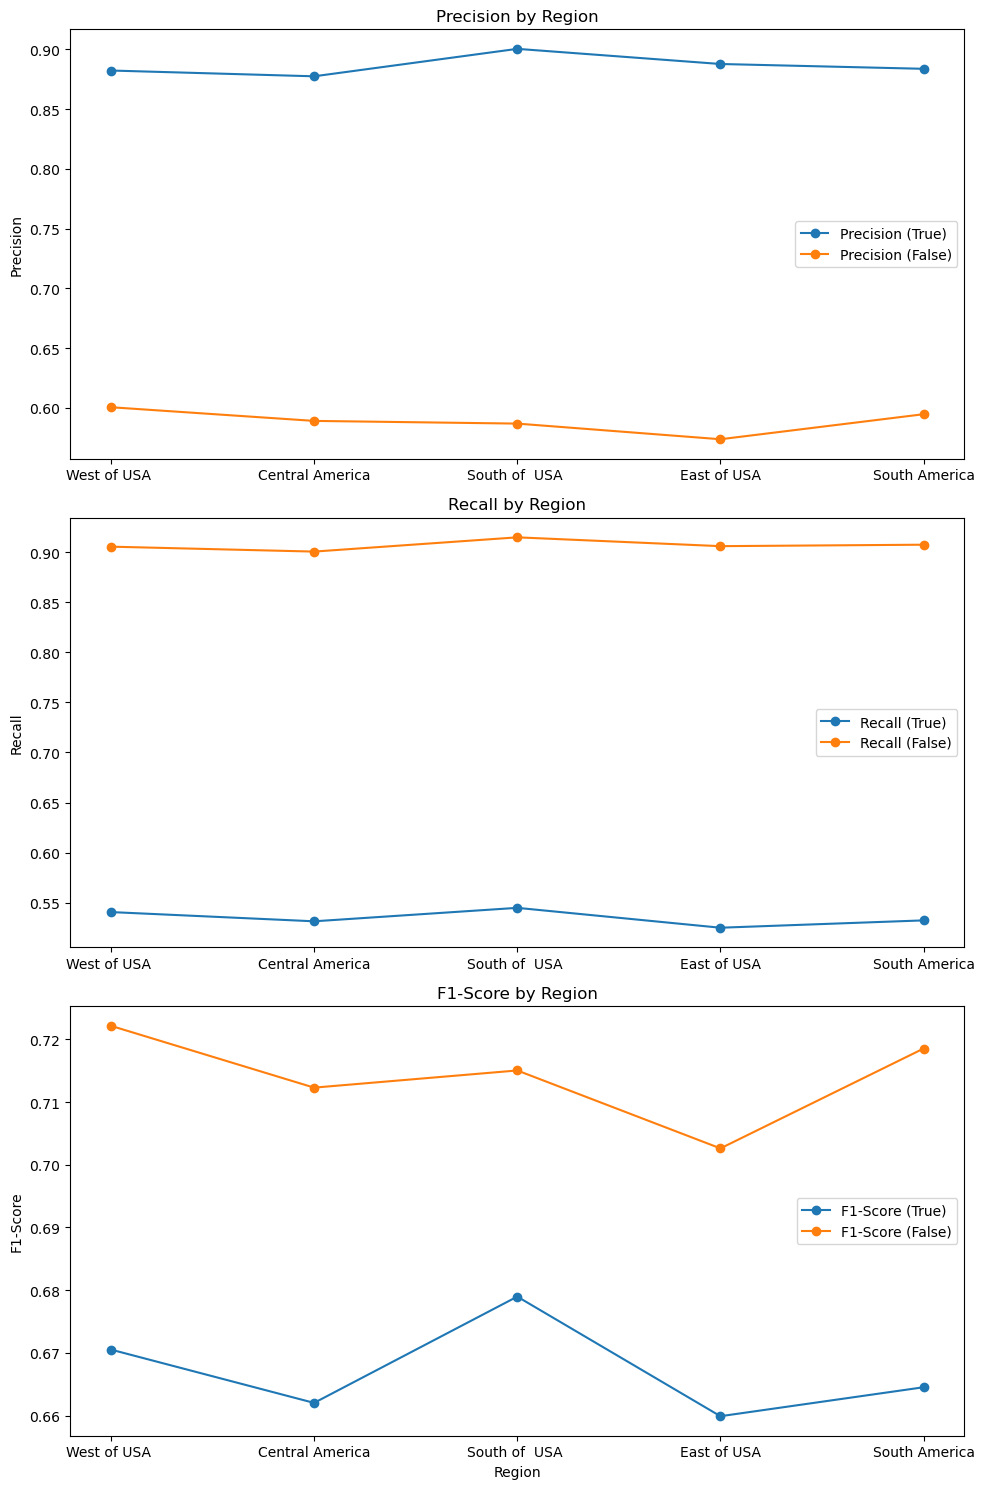

In [85]:
import matplotlib.pyplot as plt

# Plot Precision, Recall, and F1-Score for each region
fig, ax = plt.subplots(3, 1, figsize=(10, 15))

# Precision
ax[0].plot(performance_metrics_df['Region'], performance_metrics_df['Precision_True'], label='Precision (True)', marker='o')
ax[0].plot(performance_metrics_df['Region'], performance_metrics_df['Precision_False'], label='Precision (False)', marker='o')
ax[0].set_title('Precision by Region')
ax[0].set_ylabel('Precision')
ax[0].legend()

# Recall
ax[1].plot(performance_metrics_df['Region'], performance_metrics_df['Recall_True'], label='Recall (True)', marker='o')
ax[1].plot(performance_metrics_df['Region'], performance_metrics_df['Recall_False'], label='Recall (False)', marker='o')
ax[1].set_title('Recall by Region')
ax[1].set_ylabel('Recall')
ax[1].legend()

# F1-Score
ax[2].plot(performance_metrics_df['Region'], performance_metrics_df['F1-Score_True'], label='F1-Score (True)', marker='o')
ax[2].plot(performance_metrics_df['Region'], performance_metrics_df['F1-Score_False'], label='F1-Score (False)', marker='o')
ax[2].set_title('F1-Score by Region')
ax[2].set_ylabel('F1-Score')
ax[2].legend()

plt.xlabel('Region')
plt.tight_layout()
plt.show()

In [86]:
import joblib

# Load the pipeline
final_model_pipeline = joblib.load("final_model_pipeline.pkl")

# Load the optimal threshold (if saved separately)
optimal_threshold = joblib.load("optimal_threshold.pkl")


In [87]:
pip install streamlit


Note: you may need to restart the kernel to use updated packages.


In [88]:
import streamlit as st
import numpy as np

# Load the model pipeline and threshold
final_model_pipeline = joblib.load("final_model_pipeline.pkl")
optimal_threshold = joblib.load("optimal_threshold.pkl")

# Define the app
st.title("Late Delivery Risk Prediction")

# User input fields for each feature
st.header("Enter Delivery Details")
shipping_mode = st.selectbox("Shipping Mode", ["Same Day", "Second Class", "Standard Class"])
order_type = st.selectbox("Order Type", ["Payment", "Transfer", "Debit"])
order_status = st.selectbox("Order Status", ["Pending Payment", "Complete", "Closed", "On Hold"])
order_region = st.selectbox("Order Region", ["West of USA", "Central America", "South of USA", "East of USA", "South America"])

# Convert inputs into a single-row dataframe
input_data = {
    "shipping_mode": [shipping_mode],
    "type": [order_type],
    "order_status": [order_status],
    "order_region": [order_region],
}

# Predict late delivery
if st.button("Predict"):
    # Convert user input to the format required by the model pipeline
    input_df = pd.DataFrame(input_data)
    probabilities = final_model_pipeline.predict_proba(input_df)[:, 1]  # Probability for the "late" class

    # Compare probability with optimal threshold
    is_late = probabilities[0] >= optimal_threshold
    risk_score = probabilities[0] * 100

    # Display result
    if is_late:
        st.error(f"High Risk of Late Delivery! (Risk Score: {risk_score:.2f}%)")
    else:
        st.success(f"Low Risk of Late Delivery (Risk Score: {risk_score:.2f}%)")


2024-11-29 14:11:15.986 WARNING streamlit.runtime.scriptrunner_utils.script_run_context: Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.103 
  command:

    streamlit run /opt/conda/lib/python3.11/site-packages/ipykernel_launcher.py [ARGUMENTS]
2024-11-29 14:11:16.107 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.108 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.109 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.109 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.110 Thread 'MainThread': missing ScriptRunContext! This warning can be ignored when running in bare mode.
2024-11-29 14:11:16.112 Thread 'MainThread': missi